In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

from datetime import datetime as dt

# Notebook ReadME

In this notebook, I want to make a prediction on what the spread should be based on the various factors for that game.  The main variables of interest will be the team's respective elo ratings, home field advantage, and the team's qb ratings.  I want to see if I can build a predictive model given these features that accurately predicts what a spread should be.

We will start by exploring the continuous variables of interest range of values based on the spread.  Then, we'll explore how the categorical features affect the target variable. Finally, we will train a model and make predictions on the spread after we've performed feature selection.

To assess how accurate the model is, we will compare our predictions with the actual spreads to get a sense of what the average error of our predictions is.

In an ideal world, we'll be able to use this model to bet on real NFL games!

# Elo Dataset

In [2]:
elo = pd.read_csv('nfl_elo.csv')
elo.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating
0,1920-09-26,1920,0,NaN,RII,STP,1503.947,1300.000,0.824651,0.175349,...,NaN,NaN,NaN,NaN,NaN,48,0,NaN,NaN,NaN
1,1920-10-03,1920,0,NaN,CBD,PTQ,1504.688,1300.000,0.825267,0.174733,...,NaN,NaN,NaN,NaN,NaN,48,0,NaN,NaN,NaN
2,1920-10-03,1920,0,NaN,CHI,MUT,1368.333,1300.000,0.682986,0.317014,...,NaN,NaN,NaN,NaN,NaN,20,0,NaN,NaN,NaN
3,1920-10-03,1920,0,NaN,RII,MUN,1516.108,1478.004,0.644171,0.355829,...,NaN,NaN,NaN,NaN,NaN,45,0,NaN,NaN,NaN
4,1920-10-03,1920,0,NaN,DAY,COL,1493.002,1504.908,0.575819,0.424181,...,NaN,NaN,NaN,NaN,NaN,14,0,NaN,NaN,NaN


In [3]:
# filter out all games before 1980
elo = elo[elo.season >= 1980]

# rename columns
elo.rename(columns = {'date': 'schedule_date', 'team1': 'team_home', 'team2': 'team_away',
                      'score1': 'score_home', 'score2': 'score_away',
                      'elo1_pre': 'home_elo_pre', 'elo2_pre': 'away_elo_pre'}, inplace = True)

# let's whittle down the variables to the ones we think will affect the spread
elo = elo[['schedule_date', 'team_home', 'team_away', 'home_elo_pre', 'away_elo_pre', 'elo_prob1', 'elo_prob2',
           'qbelo1_pre', 'qbelo2_pre', 'qbelo_prob1', 'qbelo_prob2', 'score_home', 'score_away']]

# turn string into datetime
elo.schedule_date = elo.schedule_date.apply(lambda d: dt.strptime(d, '%Y-%m-%d'))
elo.head()

,schedule_date,team_home,team_away,home_elo_pre,away_elo_pre,elo_prob1,elo_prob2,qbelo1_pre,qbelo2_pre,qbelo_prob1,qbelo_prob2,score_home,score_away
6555,1980-09-07,CIN,TB,1470.732,1460.770,0.606236,0.393764,1466.536871,1464.160691,0.561730,0.438270,12,17
6556,1980-09-07,MIN,ATL,1452.529,1427.176,0.627174,0.372826,1450.740840,1427.566588,0.621037,0.378963,24,23
6557,1980-09-07,KC,OAK,1471.194,1546.315,0.485439,0.514561,1481.293992,1549.788298,0.492797,0.507203,14,27
6558,1980-09-07,PHI,DEN,1554.510,1550.319,0.598278,0.401722,1550.986646,1544.033387,0.614952,0.385048,27,6
6559,1980-09-07,NE,CLE,1535.825,1523.143,0.609967,0.390033,1531.627434,1518.534675,0.599850,0.400150,34,17


In [4]:
elo.describe()

,home_elo_pre,away_elo_pre,elo_prob1,elo_prob2,qbelo1_pre,qbelo2_pre,qbelo_prob1,qbelo_prob2,score_home,score_away
count,10540.000000,10540.000000,10540.000000,10540.000000,10540.000000,10540.000000,10540.000000,10540.000000,10540.000000,10540.000000
mean,1509.079862,1507.172410,0.583670,0.416330,1508.394918,1506.972934,0.576090,0.423910,22.769260,20.115275
std,99.270775,97.429821,0.167375,0.167375,95.501277,93.729969,0.172461,0.172461,10.380158,10.084739
min,1197.301000,1201.561463,0.070953,0.035422,1198.229025,1206.174113,0.059810,0.032803,0.000000,0.000000
25%,1440.088762,1439.141000,0.467052,0.290709,1442.152195,1442.242570,0.454339,0.291588,16.000000,13.000000
50%,1509.354014,1508.444000,0.593987,0.406013,1510.141196,1509.422871,0.587170,0.412830,23.000000,20.000000
75%,1577.856100,1576.818000,0.709291,0.532948,1574.050834,1574.233493,0.708412,0.545661,30.000000,27.000000
max,1839.663000,1849.484000,0.964578,0.929047,1806.390160,1814.366226,0.967197,0.940190,62.000000,59.000000


In [5]:
elo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10540 entries, 6555 to 17094
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   schedule_date  10540 non-null  datetime64[ns]
 1   team_home      10540 non-null  object        
 2   team_away      10540 non-null  object        
 3   home_elo_pre   10540 non-null  float64       
 4   away_elo_pre   10540 non-null  float64       
 5   elo_prob1      10540 non-null  float64       
 6   elo_prob2      10540 non-null  float64       
 7   qbelo1_pre     10540 non-null  float64       
 8   qbelo2_pre     10540 non-null  float64       
 9   qbelo_prob1    10540 non-null  float64       
 10  qbelo_prob2    10540 non-null  float64       
 11  score_home     10540 non-null  int64         
 12  score_away     10540 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(2), object(2)
memory usage: 1.1+ MB


# Spread Dataset

In [6]:
def team_to_city(team):
    team_cities = {'Arizona Cardinals': 'ARI', 
                   'Atlanta Falcons': 'ATL', 
                   'Baltimore Colts': 'IND',
                   'Baltimore Ravens': 'BAL', 
                   'Buffalo Bills': 'BUF', 
                   'Carolina Panthers': 'CAR',
                   'Chicago Bears': 'CHI', 
                   'Cincinnati Bengals': 'CIN', 
                   'Cleveland Browns': 'CLE',
                   'Dallas Cowboys': 'DAL', 
                   'Denver Broncos': 'DEN', 
                   'Detroit Lions': 'DET',
                   'Green Bay Packers': 'GB', 
                   'Houston Oilers': 'TEN', 
                   'Houston Texans': 'HOU',
                   'Indianapolis Colts': 'IND', 
                   'Jacksonville Jaguars': 'JAX', 
                   'Kansas City Chiefs': 'KC',
                   'Las Vegas Raiders': 'OAK', 
                   'Los Angeles Chargers': 'LAC', 
                   'Los Angeles Raiders': 'OAK',
                   'Los Angeles Rams': 'LAR', 
                   'Miami Dolphins': 'MIA', 
                   'Minnesota Vikings': 'MIN',
                   'New England Patriots': 'NE', 
                   'New Orleans Saints': 'NO', 
                   'New York Giants': 'NYG',
                   'New York Jets': 'NYJ', 
                   'Oakland Raiders': 'OAK', 
                   'Philadelphia Eagles': 'PHI',
                   'Phoenix Cardinals': 'ARI', 
                   'Pittsburgh Steelers': 'PIT', 
                   'San Diego Chargers': 'LAC',
                   'San Francisco 49ers': 'SF', 
                   'Seattle Seahawks': 'SEA', 
                   'St. Louis Cardinals': 'ARI',
                   'St. Louis Rams': 'LAR', 
                   'Tampa Bay Buccaneers': 'TB', 
                   'Tennessee Oilers': 'TEN',
                   'Tennessee Titans': 'TEN', 
                   'Washington Commanders': 'WSH',
                   'Washington Football Team': 'WSH', 
                   'Washington Redskins': 'WSH',
                   'WAS': 'WSH',
                   'LVR': 'OAK'
                  }
    
    if (team not in team_cities.keys()):
        return team
    
    return team_cities[team]

In [7]:
spreads = pd.read_csv('spreadspoke_scores.csv')

# filter out all data before 1980
spreads = spreads[spreads.schedule_season >= 1980]

# rename teams
spreads.team_home = spreads.team_home.apply(lambda t: team_to_city(t))
spreads.team_away = spreads.team_away.apply(lambda t: team_to_city(t))
spreads.team_favorite_id = spreads.team_favorite_id.apply(lambda t: team_to_city(t))

# turn string into date
spreads.schedule_date = spreads.schedule_date.apply(lambda d: dt.strptime(d, '%m/%d/%Y'))

# filter out unnecessary columns
spreads = spreads[['schedule_date', 'team_home', 'score_home', 'score_away', 'team_away', 'team_favorite_id', 
                   'spread_favorite', 'over_under_line']]

spreads.head()

,schedule_date,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line
2734,1980-09-07,BUF,17,7,MIA,MIA,-3.0,35
2735,1980-09-07,CIN,12,17,TB,TB,-1.0,34
2736,1980-09-07,GB,12,6,CHI,CHI,-6.0,35
2737,1980-09-07,KC,14,27,OAK,KC,-3.0,42
2738,1980-09-07,LAR,20,41,DET,LAR,-9.0,38


In [8]:
spreads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10782 entries, 2734 to 13515
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   schedule_date     10782 non-null  datetime64[ns]
 1   team_home         10782 non-null  object        
 2   score_home        10782 non-null  int64         
 3   score_away        10782 non-null  int64         
 4   team_away         10782 non-null  object        
 5   team_favorite_id  10782 non-null  object        
 6   spread_favorite   10782 non-null  float64       
 7   over_under_line   10782 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 758.1+ KB


## Join Datasets

In [9]:
df = pd.merge(elo, spreads, on = ['schedule_date', 'team_home', 'team_away', 'score_home', 'score_away'], how = 'inner')

# organize df
df = df[['schedule_date', 'team_home', 'score_home', 'score_away', 'team_away', 'team_favorite_id', 
         'spread_favorite', 'over_under_line', 'home_elo_pre', 'away_elo_pre', 'elo_prob1', 'elo_prob2',
         'qbelo1_pre', 'qbelo2_pre', 'qbelo_prob1', 'qbelo_prob2']]
df

,schedule_date,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,home_elo_pre,away_elo_pre,elo_prob1,elo_prob2,qbelo1_pre,qbelo2_pre,qbelo_prob1,qbelo_prob2
0,1980-09-07,CIN,12,17,TB,TB,-1.0,34,1470.732000,1460.770000,0.606236,0.393764,1466.536871,1464.160691,0.561730,0.438270
1,1980-09-07,MIN,24,23,ATL,MIN,-4.0,42,1452.529000,1427.176000,0.627174,0.372826,1450.740840,1427.566588,0.621037,0.378963
2,1980-09-07,KC,14,27,OAK,KC,-3.0,42,1471.194000,1546.315000,0.485439,0.514561,1481.293992,1549.788298,0.492797,0.507203
3,1980-09-07,PHI,27,6,DEN,PHI,-3.0,38,1554.510000,1550.319000,0.598278,0.401722,1550.986646,1544.033387,0.614952,0.385048
4,1980-09-07,NE,34,17,CLE,NE,-6.0,38,1535.825000,1523.143000,0.609967,0.390033,1531.627434,1518.534675,0.599850,0.400150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10460,2022-01-23,TB,27,30,LAR,TB,-3.0,48,1681.797158,1632.341105,0.659005,0.340995,1649.547292,1615.165080,0.681440,0.318560
10461,2022-01-23,KC,42,36,BUF,KC,-2.5,54,1699.470145,1683.332367,0.614689,0.385311,1687.450699,1656.910634,0.652720,0.347280
10462,2022-01-30,KC,24,27,CIN,KC,-7.0,54.5,1713.932369,1569.498961,0.769519,0.230481,1700.324756,1559.717895,0.810417,0.189583
10463,2022-01-30,LAR,20,17,SF,LAR,-3.5,46,1651.615346,1621.465562,0.633608,0.366392,1635.265484,1631.632019,0.636093,0.363907


# Engineer Variables of Interest

In [10]:
def get_home_diff(df):
    home_elo_diff = df.home_elo_pre - df.away_elo_pre
        
    return home_elo_diff

In [11]:
def get_home_favorite(df):
    if (df.team_home == df.team_favorite_id):
        home_favorite = 1
    else:
        home_favorite = 0
        
    return home_favorite

In [12]:
def get_home_spread(df):
    """
    return absolute value of spread for home team if they are not favored
    """
    if (df.team_home != df.team_favorite_id):
        return abs(df.spread_favorite)
    else:
        return df.spread_favorite

In [13]:
df.head()

,schedule_date,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,home_elo_pre,away_elo_pre,elo_prob1,elo_prob2,qbelo1_pre,qbelo2_pre,qbelo_prob1,qbelo_prob2
0,1980-09-07,CIN,12,17,TB,TB,-1.0,34,1470.732,1460.770,0.606236,0.393764,1466.536871,1464.160691,0.561730,0.438270
1,1980-09-07,MIN,24,23,ATL,MIN,-4.0,42,1452.529,1427.176,0.627174,0.372826,1450.740840,1427.566588,0.621037,0.378963
2,1980-09-07,KC,14,27,OAK,KC,-3.0,42,1471.194,1546.315,0.485439,0.514561,1481.293992,1549.788298,0.492797,0.507203
3,1980-09-07,PHI,27,6,DEN,PHI,-3.0,38,1554.510,1550.319,0.598278,0.401722,1550.986646,1544.033387,0.614952,0.385048
4,1980-09-07,NE,34,17,CLE,NE,-6.0,38,1535.825,1523.143,0.609967,0.390033,1531.627434,1518.534675,0.599850,0.400150


In [14]:
# create elo diff column for exploration
df['home_elo_diff'] = df.apply(lambda record: get_home_diff(record), axis = 1)
df['home_favorite'] = df.apply(lambda record: get_home_favorite(record), axis = 1)
df['home_spread'] = df.apply(lambda record: get_home_spread(record), axis = 1)
df.head(10)

,schedule_date,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,home_elo_pre,away_elo_pre,elo_prob1,elo_prob2,qbelo1_pre,qbelo2_pre,qbelo_prob1,qbelo_prob2,home_elo_diff,home_favorite,home_spread
0,1980-09-07,CIN,12,17,TB,TB,-1.0,34,1470.732,1460.770,0.606236,0.393764,1466.536871,1464.160691,0.561730,0.438270,9.962,0,1.0
1,1980-09-07,MIN,24,23,ATL,MIN,-4.0,42,1452.529,1427.176,0.627174,0.372826,1450.740840,1427.566588,0.621037,0.378963,25.353,1,-4.0
2,1980-09-07,KC,14,27,OAK,KC,-3.0,42,1471.194,1546.315,0.485439,0.514561,1481.293992,1549.788298,0.492797,0.507203,-75.121,1,-3.0
3,1980-09-07,PHI,27,6,DEN,PHI,-3.0,38,1554.510,1550.319,0.598278,0.401722,1550.986646,1544.033387,0.614952,0.385048,4.191,1,-3.0
4,1980-09-07,NE,34,17,CLE,NE,-6.0,38,1535.825,1523.143,0.609967,0.390033,1531.627434,1518.534675,0.599850,0.400150,12.682,1,-6.0
5,1980-09-07,ARI,35,41,NYG,ARI,-7.0,42,1457.916,1423.201,0.639687,0.360313,1466.861748,1419.189867,0.653587,0.346413,34.715,1,-7.0
6,1980-09-07,BUF,17,7,MIA,MIA,-3.0,35,1465.161,1546.464,0.476555,0.523445,1461.832866,1547.698661,0.461703,0.538297,-81.303,0,3.0
7,1980-09-07,LAR,20,41,DET,LAR,-9.0,38,1536.751,1380.659,0.781206,0.218794,1555.266435,1397.834896,0.769405,0.230595,156.092,1,-9.0
8,1980-09-07,NO,23,26,SF,NO,-4.0,45,1505.008,1364.838,0.765137,0.234863,1497.963718,1358.733383,0.759192,0.240808,140.170,1,-4.0
9,1980-09-07,SEA,13,34,LAC,LAC,-2.0,45,1532.664,1609.009,0.483679,0.516321,1527.640860,1599.671937,0.488073,0.511927,-76.345,0,2.0


## Continuous Data Exploration

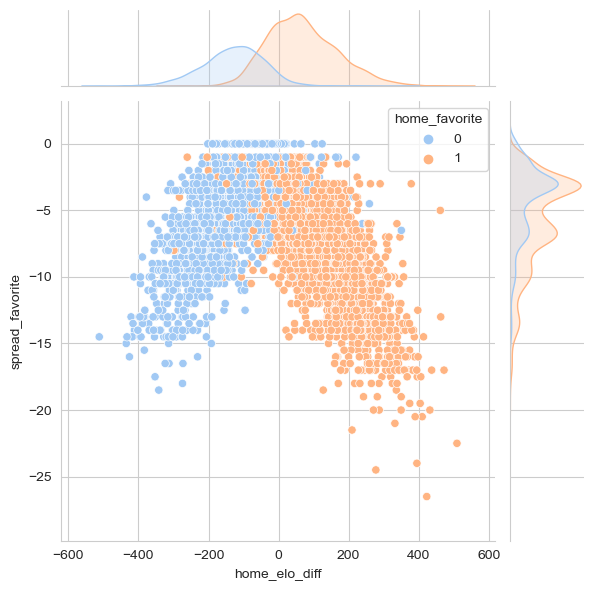

In [15]:
sns.jointplot(data = df, x = 'home_elo_diff', y = 'spread_favorite', hue = 'home_favorite')
plt.show()

In [16]:
# home favorites seems to have more outliers where they are the lower elo
# Let's confirm this with grouping by home favorite
df.groupby('home_favorite').aggregate({'home_elo_diff': 'mean'})

,home_elo_diff
home_favorite,
0,-130.023772
1,67.649563


# Modeling

In [17]:
predictors = ['home_elo_diff']
target = 'home_spread'

X = df[predictors]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state = 21)


# create pipeline to standardize datasets
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

X_train_tr = pipeline.fit_transform(X_train)
X_test_tr = pipeline.fit_transform(X_test)

## Random Forest

In [18]:
# define model
rf_model = RandomForestRegressor(n_estimators = 150, criterion = 'absolute_error', max_depth = 10)

# train model
rf_model.fit(X_train_tr, y_train)

# make predictions
rf_predictions = rf_model.predict(X_test_tr)

# assess accuracy of model
rf_score = mean_absolute_error(y_test, rf_predictions)
print("Random forest absolute error:", np.round(rf_score, 3))

Random forest absolute error: 2.138


## Linear Regression

In [19]:
linear_model = LinearRegression()
linear_model.fit(X_train_tr, y_train)

# make predictions
linear_predictions = linear_model.predict(X_test_tr)

# get average error
linear_score = mean_absolute_error(y_test, linear_predictions)
print("Linear Model Absolute Error:", np.round(linear_score, 3))

Linear Model Absolute Error: 2.131


# Conclusion

Both models are off on the spread by an average of 2.1 points.  With such a large margin of error when predicting the spread for the home team, this model cannot be relied on to make predictions on future spreads for a home team given the team's respective ELO ratings.